In [1]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:85% !important; }</style>"))

In [2]:
# set the matplotlib backend so figures can be saved in the background
import matplotlib
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import classification_report
from keras.layers.normalization.batch_normalization import BatchNormalization
from keras.layers.convolutional.conv2d import Conv2D
from keras.layers.convolutional import AveragePooling2D
from keras.layers.convolutional import MaxPooling2D
from keras.layers.core import Activation
from keras.layers.core import Dropout
from keras.layers.core import Dense
from keras.layers import Flatten
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.datasets import fashion_mnist
from keras.layers import Flatten
from keras.layers import Input
from keras.models import Model
from keras.layers import concatenate
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2
import sys
from tensorflow.keras.callbacks import LambdaCallback
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import numpy as np
import tempfile
import tensorflow
from tensorflow import keras

2023-01-06 19:16:15.965450: I tensorflow/core/util/util.cc:169] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


In [3]:
# import the necessary packages

class LearningRateFinder:
    def __init__(self, model, stopFactor=4, beta=0.98):
        # store the model, stop factor, and beta value (for computing
        # a smoothed, average loss)
        self.model = model
        self.stopFactor = stopFactor
        self.beta = beta
        # initialize our list of learning rates and losses,
        # respectively
        self.lrs = []
        self.losses = []
        # initialize our learning rate multiplier, average loss, best
        # loss found thus far, current batch number, and weights file
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None
        
    def reset(self):
        # re-initialize all variables from our constructor
        self.lrs = []
        self.losses = []
        self.lrMult = 1
        self.avgLoss = 0
        self.bestLoss = 1e9
        self.batchNum = 0
        self.weightsFile = None

    def is_data_iter(self, data):
            # define the set of class types we will check for
            iterClasses = ["NumpyArrayIterator", "DirectoryIterator",
                 "DataFrameIterator", "Iterator", "Sequence"]
            # return whether our data is an iterator
            return data.__class__.__name__ in iterClasses

    def on_batch_end(self, batch, logs):
        # grab the current learning rate and add log it to the list of
        # learning rates that we've tried
        lr = K.get_value(self.model.optimizer.learning_rate)
        self.lrs.append(lr)
        # grab the loss at the end of this batch, increment the total
        # number of batches processed, compute the average average
        # loss, smooth it, and update the losses list with the
        # smoothed value
        l = logs["loss"]
        self.batchNum += 1
        self.avgLoss = (self.beta * self.avgLoss) + ((1 - self.beta) * l)
        smooth = self.avgLoss / (1 - (self.beta ** self.batchNum))
        self.losses.append(smooth)
        # compute the maximum loss stopping factor value
        stopLoss = self.stopFactor * self.bestLoss
        # check to see whether the loss has grown too large
        if self.batchNum > 1 and smooth > stopLoss:
            # stop returning and return from the method
            self.model.stop_training = True
            return
        # check to see if the best loss should be updated
        if self.batchNum == 1 or smooth < self.bestLoss:
            self.bestLoss = smooth
        # increase the learning rate
        lr *= self.lrMult
        K.set_value(self.model.optimizer.lr, lr)
    
    def find(self, trainData, startLR, endLR, epochs=None,stepsPerEpoch=None, batchSize=32, sampleSize=2048,verbose=1):
        # reset our class-specific variables
        self.reset()
        # determine if we are using a data generator or not
        useGen = self.is_data_iter(trainData)
        # if we're using a generator and the steps per epoch is not
        # supplied, raise an error
        if useGen and stepsPerEpoch is None:
            msg = "Using generator without supplying stepsPerEpoch"
            raise Exception(msg)
        # if we're not using a generator then our entire dataset must
        # already be in memory
        elif not useGen:
            # grab the number of samples in the training data and
            # then derive the number of steps per epoch
            numSamples = len(trainData[0])
            stepsPerEpoch = np.ceil(numSamples / float(batchSize))
        # if no number of training epochs are supplied, compute the
        # training epochs based on a default sample size
        if epochs is None:
            epochs = int(np.ceil(sampleSize / float(stepsPerEpoch)))
        # compute the total number of batch updates that will take
        # place while we are attempting to find a good starting
        # learning rate
        numBatchUpdates = epochs * stepsPerEpoch
        # derive the learning rate multiplier based on the ending
        # learning rate, starting learning rate, and total number of
        # batch updates
        self.lrMult = (endLR / startLR) ** (1.0 / numBatchUpdates)
        # create a temporary file path for the model weights and
        # then save the weights (so we can reset the weights when we
        # are done)
        self.weightsFile = tempfile.mkstemp()[1]
        self.model.save_weights(self.weightsFile)
        # grab the *original* learning rate (so we can reset it
        # later), and then set the *starting* learning rate
        origLR = K.get_value(self.model.optimizer.lr)
        K.set_value(self.model.optimizer.lr, startLR)
        # construct a callback that will be called at the end of each
        # batch, enabling us to increase our learning rate as training
        # progresses
        callback = LambdaCallback(on_batch_end=lambda batch, logs:
            self.on_batch_end(batch, logs))
        # check to see if we are using a data iterator
        if useGen:
            self.model.fit(
                x=trainData,
                steps_per_epoch=stepsPerEpoch,
                epochs=epochs,
                verbose=verbose,
                callbacks=[callback])
        # otherwise, our entire training data is already in memory
        else:
            # train our model using Keras' fit method
            self.model.fit(
                x=trainData[0], y=trainData[1],
                batch_size=batchSize,
                epochs=epochs,
                callbacks=[callback],
                verbose=verbose)
        # restore the original model weights and learning rate
        self.model.load_weights(self.weightsFile)
        K.set_value(self.model.optimizer.lr, origLR)

    def plot_loss(self, skipBegin=10, skipEnd=1, title=""):
        # grab the learning rate and losses values to plot
        lrs = self.lrs[skipBegin:-skipEnd]
        losses = self.losses[skipBegin:-skipEnd]
        # plot the learning rate vs. loss
        plt.plot(lrs, losses)
        plt.xscale("log")
        plt.xlabel("Learning Rate (Log Scale)")
        plt.ylabel("Loss")
        # if the title is not empty, add it to the plot
        if title != "":
            plt.title(title)

In [4]:
def conv_module(input,No_of_filters,filtersizeX,filtersizeY,stride,chanDim,padding="same"):
    input = Conv2D(No_of_filters,(filtersizeX,filtersizeY),strides=stride,padding=padding)(input)
    input = BatchNormalization(axis=chanDim)(input)
    input = Activation("relu")(input)
    return input

def inception_module(input,numK1x1,numK3x3,numk5x5,numPoolProj,chanDim):
                                 #Step 1
    conv_1x1 = conv_module(input, numK1x1, 1, 1,(1, 1), chanDim) 
                                 #Step 2
    conv_3x3 = conv_module(input, numK3x3, 3, 3,(1, 1), chanDim)
    conv_5x5 = conv_module(input, numk5x5, 5, 5,(1, 1), chanDim)
                                 #Step 3
    pool_proj = MaxPooling2D((3, 3), strides=(1, 1), padding='same')(input)
    pool_proj = Conv2D(numPoolProj, (1, 1), padding='same', activation='relu')(pool_proj)
                                 #Step 4
    input = concatenate([conv_1x1, conv_3x3, conv_5x5, pool_proj], axis=chanDim)
    return input

def downsample_module(input,No_of_filters,chanDim):
    conv_3x3=conv_module(input,No_of_filters,3,3,(2,2),chanDim,padding="valid")
    pool = MaxPooling2D((3,3),strides=(2,2))(input)
    input = concatenate([conv_3x3,pool],axis=chanDim)
    return input

In [5]:
def MiniGoogleNet(width,height,depth,classes):
    inputShape=(height,width,depth)
    chanDim=-1

    # (Step 1) Define the model input
    inputs = Input(shape=inputShape)

    # First CONV module
    x = conv_module(inputs, 96, 3, 3, (1, 1),chanDim)

    # (Step 2) Two Inception modules followed by a downsample module
    x = inception_module(x, 32, 32,32,32,chanDim)
    x = inception_module(x, 32, 48, 48,32,chanDim)
    x = downsample_module(x, 80, chanDim)

    # (Step 3) Five Inception modules followed by a downsample module
    x = inception_module(x, 112, 48, 32, 48,chanDim)
    x = inception_module(x, 96, 64, 32,32,chanDim)
    x = inception_module(x, 80, 80, 32,32,chanDim)
    x = inception_module(x, 48, 96, 32,32,chanDim)
    x = inception_module(x, 112, 48, 32, 48,chanDim)
    x = downsample_module(x, 96, chanDim)

    # (Step 4) Two Inception modules followed
    x = inception_module(x, 176, 160,96,96, chanDim)
    x = inception_module(x, 176, 160, 96,96,chanDim)

    # Global POOL and dropout
    x = AveragePooling2D((7, 7))(x)
    x = Dropout(0.5)(x)

    # (Step 5) Softmax classifier
    x = Flatten()(x)
    x = Dense(classes)(x)
    x = Activation("softmax")(x)

    # Create the model
    model = Model(inputs, x, name="googlenet")
    return model

In [6]:
# import the necessary packages
import os
# initialize the list of class label names
CLASSES = ["top", "trouser", "pullover", "dress", "coat",
	"sandal", "shirt", "sneaker", "bag", "ankle boot"]
# define the minimum learning rate, maximum learning rate, batch size,
# step size, CLR method, and number of epochs
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 64
STEP_SIZE = 8
CLR_METHOD = "triangular"
NUM_EPOCHS = 48
# define the path to the output learning rate finder plot, training
# history plot and cyclical learning rate plot
LRFIND_PLOT_PATH = os.path.sep.join(["./", "lrfind_plot.png"])
TRAINING_PLOT_PATH = os.path.sep.join(["./", "training_plot.png"])
CLR_PLOT_PATH = os.path.sep.join(["./", "clr_plot.png"])

In [7]:
print("[INFO] compiling model...")
opt = SGD(learning_rate=MIN_LR, momentum=0.9)
model = MiniGoogleNet(width=32, height=32, depth=1, classes=10)
model.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model...


2023-01-06 19:16:19.626801: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 19:16:19.687416: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 19:16:19.687697: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:975] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-01-06 19:16:19.688448: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the approp

In [8]:
# load the training and testing data
print("[INFO] loading Fashion MNIST data...")
((trainX, trainY), (testX, testY)) = fashion_mnist.load_data()
# Fashion MNIST images are 28x28 but the network we will be training
# is expecting 32x32 images
trainX = np.array([cv2.resize(x, (32, 32)) for x in trainX])
testX = np.array([cv2.resize(x, (32, 32)) for x in testX])
# scale the pixel intensities to the range [0, 1]
trainX = trainX.astype("float") / 255.0
testX = testX.astype("float") / 255.0
# reshape the data matrices to include a channel dimension (required
# for training)
trainX = trainX.reshape((trainX.shape[0], 32, 32, 1))
testX = testX.reshape((testX.shape[0], 32, 32, 1))
# convert the labels from integers to vectors
lb = LabelBinarizer()
trainY = lb.fit_transform(trainY)
testY = lb.transform(testY)
# construct the image generator for data augmentation
aug = ImageDataGenerator(width_shift_range=0.1,
	height_shift_range=0.1, horizontal_flip=True,
	fill_mode="nearest")


[INFO] loading Fashion MNIST data...


#### 1. Fix batch size to 64 and start with 10 candidate learning rates between 10^−9 and 10 and train your model for 5 epochs. Plot the training loss as a function of the learning rate. You should see a curve like Figure 3 in the reference below. From that figure identify the values of lrmin and lrmax.

In [9]:
from tensorflow.keras.callbacks import *
class CyclicLR(Callback):
    """This callback implements a cyclical learning rate policy (CLR).
    The method cycles the learning rate between two boundaries with
    some constant frequency, as detailed in this paper (https://arxiv.org/abs/1506.01186).
    The amplitude of the cycle can be scaled on a per-iteration or
    per-cycle basis.
    This class has three built-in policies, as put forth in the paper.
    "triangular":
        A basic triangular cycle w/ no amplitude scaling.
    "triangular2":
        A basic triangular cycle that scales initial amplitude by half each cycle.
    "exp_range":
        A cycle that scales initial amplitude by gamma**(cycle iterations) at each
        cycle iteration.
    For more detail, please see paper.

    # Example
        ```python
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., mode='triangular')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```

    Class also supports custom scaling functions:
        ```python
            clr_fn = lambda x: 0.5*(1+np.sin(x*np.pi/2.))
            clr = CyclicLR(base_lr=0.001, max_lr=0.006,
                                step_size=2000., scale_fn=clr_fn,
                                scale_mode='cycle')
            model.fit(X_train, Y_train, callbacks=[clr])
        ```
    # Arguments
        base_lr: initial learning rate which is the
            lower boundary in the cycle.
        max_lr: upper boundary in the cycle. Functionally,
            it defines the cycle amplitude (max_lr - base_lr).
            The lr at any cycle is the sum of base_lr
            and some scaling of the amplitude; therefore
            max_lr may not actually be reached depending on
            scaling function.
        step_size: number of training iterations per
            half cycle. Authors suggest setting step_size
            2-8 x training iterations in epoch.
        mode: one of {triangular, triangular2, exp_range}.
            Default 'triangular'.
            Values correspond to policies detailed above.
            If scale_fn is not None, this argument is ignored.
        gamma: constant in 'exp_range' scaling function:
            gamma**(cycle iterations)
        scale_fn: Custom scaling policy defined by a single
            argument lambda function, where
            0 <= scale_fn(x) <= 1 for all x >= 0.
            mode paramater is ignored
        scale_mode: {'cycle', 'iterations'}.
            Defines whether scale_fn is evaluated on
            cycle number or cycle iterations (training
            iterations since start of cycle). Default is 'cycle'.
    """

    def __init__(
        self,
        base_lr=0.001,
        max_lr=0.006,
        step_size=2000.0,
        mode="triangular",
        gamma=1.0,
        scale_fn=None,
        scale_mode="cycle",
    ):
        super(CyclicLR, self).__init__()

        self.base_lr = base_lr
        self.max_lr = max_lr
        self.step_size = step_size
        self.mode = mode
        self.gamma = gamma
        if scale_fn == None:
            if self.mode == "triangular":
                self.scale_fn = lambda x: 1.0
                self.scale_mode = "cycle"
            elif self.mode == "triangular2":
                self.scale_fn = lambda x: 1 / (2.0 ** (x - 1))
                self.scale_mode = "cycle"
            elif self.mode == "exp_range":
                self.scale_fn = lambda x: gamma ** (x)
                self.scale_mode = "iterations"
        else:
            self.scale_fn = scale_fn
            self.scale_mode = scale_mode
        self.clr_iterations = 0.0
        self.trn_iterations = 0.0
        self.history = {}

        self._reset()

    def _reset(self, new_base_lr=None, new_max_lr=None, new_step_size=None):
        """Resets cycle iterations.
        Optional boundary/step size adjustment.
        """
        if new_base_lr != None:
            self.base_lr = new_base_lr
        if new_max_lr != None:
            self.max_lr = new_max_lr
        if new_step_size != None:
            self.step_size = new_step_size
        self.clr_iterations = 0.0

    def clr(self):
        cycle = np.floor(1 + self.clr_iterations / (2 * self.step_size))
        x = np.abs(self.clr_iterations / self.step_size - 2 * cycle + 1)
        if self.scale_mode == "cycle":
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(
                0, (1 - x)
            ) * self.scale_fn(cycle)
        else:
            return self.base_lr + (self.max_lr - self.base_lr) * np.maximum(
                0, (1 - x)
            ) * self.scale_fn(self.clr_iterations)

    def on_train_begin(self, logs={}):
        logs = logs or {}

        if self.clr_iterations == 0:
            K.set_value(self.model.optimizer.lr, self.base_lr)
        else:
            K.set_value(self.model.optimizer.lr, self.clr())

    def on_batch_end(self, epoch, logs=None):
 
        logs = logs or {}
        self.trn_iterations += 1
        self.clr_iterations += 1

        self.history.setdefault("lr", []).append(K.get_value(self.model.optimizer.lr))
        self.history.setdefault("iterations", []).append(self.trn_iterations)
        self.history.setdefault("noiseratio", []).append(self.model.optimizer.lr*60000/32)
        
        for k, v in logs.items():
            self.history.setdefault(k, []).append(v)

        K.set_value(self.model.optimizer.lr, self.clr())

#### 2. Use the cyclical learning rate policy (with exponential decay) and train your network using batch size 64 and lrmin and lrmax values obtained in part 1. Plot train/validation loss and accuracy curve (similar to Figure 4 in reference). 

In [10]:
MIN_LR = 1e-5
MAX_LR = 1e-2
BATCH_SIZE = 32
STEP_SIZE = 8
CLR_METHOD = "exp_range"
NUM_EPOCHS = 16

In [11]:
print("[INFO] compiling model to reset parameters")
model1 = MiniGoogleNet(width=32, height=32, depth=1, classes=10)
model1.compile(loss="categorical_crossentropy", optimizer=opt,
    metrics=["accuracy"])

[INFO] compiling model to reset parameters


In [12]:
stepSize = STEP_SIZE * (trainX.shape[0] // BATCH_SIZE)
clr = CyclicLR(
    mode=CLR_METHOD,
    base_lr=MIN_LR,
    max_lr=MAX_LR,
    step_size=stepSize,
#     gamma=np.e,
)
# train the network
print("[INFO] training network...")
H = model1.fit(
    x=aug.flow(trainX, trainY, batch_size=BATCH_SIZE),
    validation_data=(testX, testY),
    steps_per_epoch=trainX.shape[0] // BATCH_SIZE,
    epochs=NUM_EPOCHS,
    callbacks=[clr],
    verbose=1)


[INFO] training network...
Epoch 1/16


2023-01-06 19:16:24.542207: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8400
2023-01-06 19:16:25.843855: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-06 19:16:25.844280: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-06 19:16:25.844289: W tensorflow/stream_executor/gpu/asm_compiler.cc:80] Couldn't get ptxas version string: INTERNAL: Couldn't invoke ptxas --version
2023-01-06 19:16:25.844588: I tensorflow/core/platform/default/subprocess.cc:304] Start cannot spawn child process: No such file or directory
2023-01-06 19:16:25.844620: W tensorflow/stream_executor/gpu/redzone_allocator.cc:314] INTERNAL: Failed to launch ptxas
Relying on driver to perform ptx compilation. 
Modify $PATH to customize ptxas location.
This message will be only logged once.
2023-01-06 19:16:26.544125: I tensorflow/stream_executor/cuda/c

1875/1875 [==============================] - 105s 53ms/step - loss: 0.8513 - accuracy: 0.6981 - val_loss: 0.9286 - val_accuracy: 0.6801
Epoch 2/16
1875/1875 [==============================] - 100s 53ms/step - loss: 0.4228 - accuracy: 0.8458 - val_loss: 0.4890 - val_accuracy: 0.8370
Epoch 3/16
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3471 - accuracy: 0.8743 - val_loss: 0.4710 - val_accuracy: 0.8391
Epoch 4/16
1875/1875 [==============================] - 99s 53ms/step - loss: 0.3095 - accuracy: 0.8882 - val_loss: 0.4864 - val_accuracy: 0.8433
Epoch 5/16
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2853 - accuracy: 0.8970 - val_loss: 0.5672 - val_accuracy: 0.8070
Epoch 6/16
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2701 - accuracy: 0.9019 - val_loss: 0.2984 - val_accuracy: 0.8927
Epoch 7/16
1875/1875 [==============================] - 99s 53ms/step - loss: 0.2556 - accuracy: 0.9074 - val_loss: 0.2365 - val_accu

In [13]:
# evaluate the network and show a classification report
print("[INFO] evaluating network...")
predictions = model1.predict(x=testX, batch_size=BATCH_SIZE)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))

[INFO] evaluating network...
313/313 [==============================] - 5s 16ms/step
              precision    recall  f1-score   support

         top       0.90      0.89      0.90      1000
     trouser       0.99      0.99      0.99      1000
    pullover       0.92      0.92      0.92      1000
       dress       0.94      0.94      0.94      1000
        coat       0.92      0.93      0.92      1000
      sandal       0.99      0.99      0.99      1000
       shirt       0.83      0.84      0.84      1000
     sneaker       0.96      0.98      0.97      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.96      0.97      1000

    accuracy                           0.94     10000
   macro avg       0.94      0.94      0.94     10000
weighted avg       0.94      0.94      0.94     10000



In [14]:
print(f"[REFERENCE] Number of iterations per epoch: {trainX.shape[0] // BATCH_SIZE}")

[REFERENCE] Number of iterations per epoch: 1875


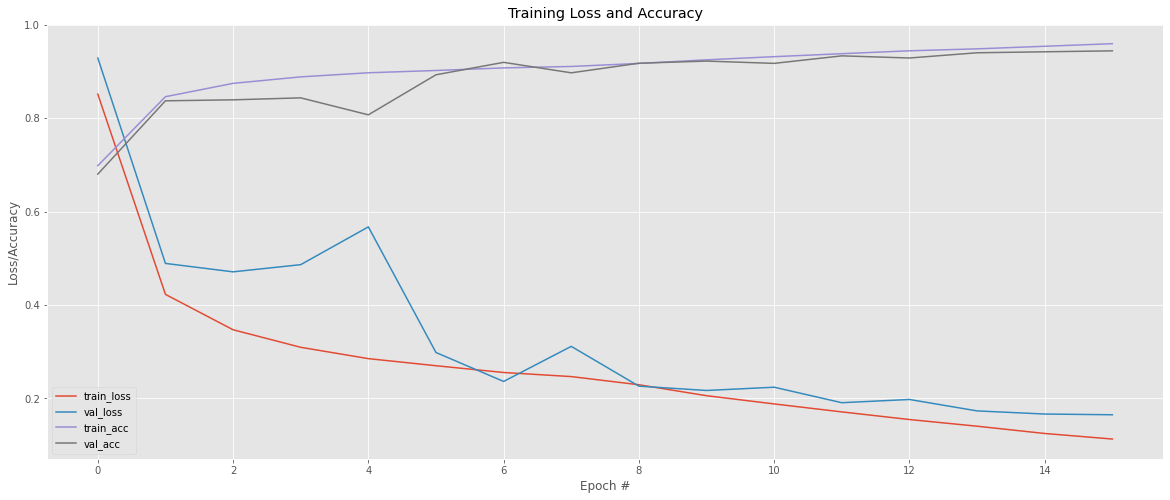

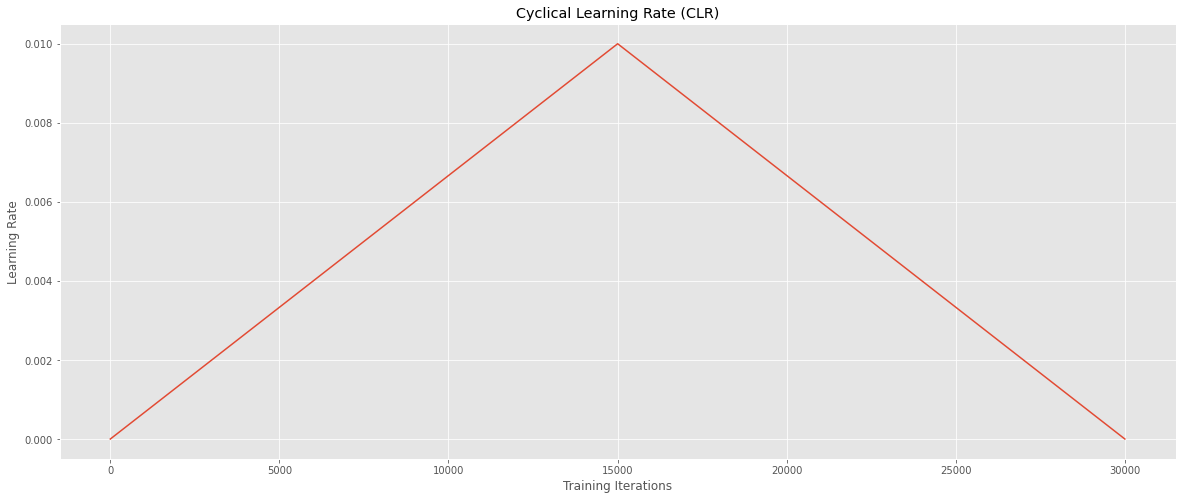

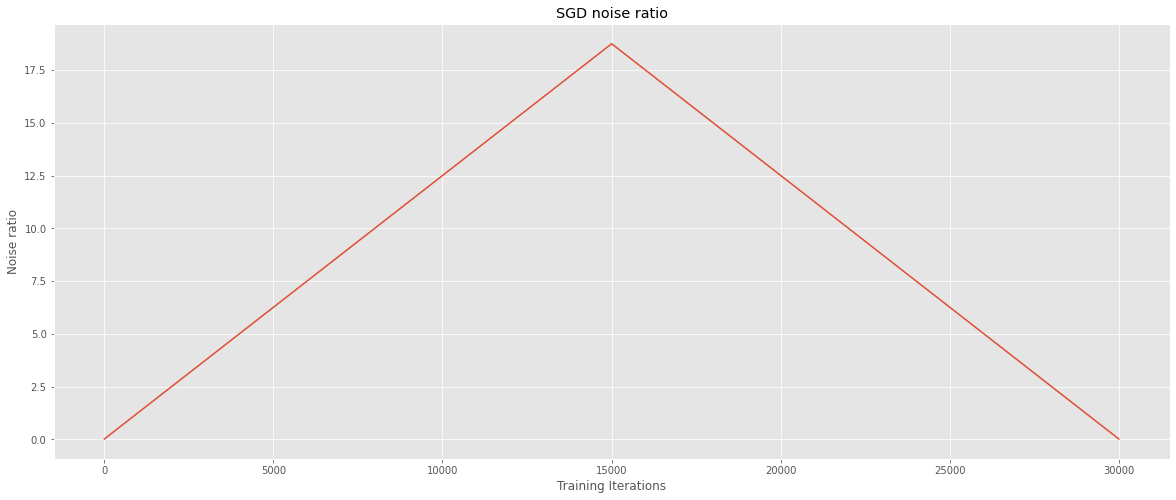

In [15]:
prefix = "LearningRateVariationModel_"
# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,8))
plt.plot(N, H.history["loss"], label="train_loss")
plt.plot(N, H.history["val_loss"], label="val_loss")
plt.plot(N, H.history["accuracy"], label="train_acc")
plt.plot(N, H.history["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(prefix+"AccuracyLoss.jpg", dpi=440)
plt.show()
# plot the learning rate history
N = np.arange(0, len(clr.history["lr"]))
plt.figure(figsize=(20,8))
plt.plot(N, clr.history["lr"])
plt.title("Cyclical Learning Rate (CLR)")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(prefix+"CyclicLearningRate.jpg", dpi=440)
plt.show()
# plot noise ration history
N = np.arange(0, len(clr.history["noiseratio"]))
plt.figure(figsize=(20,8))
plt.plot(N, clr.history["noiseratio"])
plt.title("SGD noise ratio")
plt.xlabel("Training Iterations")
plt.ylabel("Noise ratio")
plt.savefig(prefix+"NoiseRatio.jpg", dpi=440)
plt.show()

In [16]:
train_dataset = aug.flow(trainX, trainY, batch_size=32)

In [17]:
# 1, 1, 1, 2, 4, 10, 20, 31, 75, 129

# If we wanna vary it over 1 epoch
# batches = [201, 69, 32, 16, 8, 4, 2, 1, 1, 1] 

# If we wanna vary it over 2 epochs
batches = [1024, 275, 96, 32, 16, 4, 2, 2, 1, 1]

# If we wanna vary it over 8 epochs
batches = [4074, 2049, 423, 202, 60, 16, 8, 4, 2, 1]

In [18]:
print("[INFO] compiling model, to reset weights for varying batch sizes")
model = MiniGoogleNet(width=32, height=32, depth=1, classes=10)
opt = SGD(learning_rate=MAX_LR, momentum=0.9)
loss_fn = keras.losses.CategoricalCrossentropy(from_logits=False)

[INFO] compiling model, to reset weights for varying batch sizes


In [19]:
history_object = {
    "loss":[],
    "accuracy":[],
    "val_loss":[],
    "val_accuracy":[],
}

In [20]:
train_acc_metric = keras.metrics.CategoricalAccuracy()
val_acc_metric = keras.metrics.CategoricalAccuracy()

In [21]:
batchSizeVariation = []
noiseRatio = []

In [22]:
switchEvery = 8
period = switchEvery * 2

In [23]:
for epoch in range(NUM_EPOCHS):
    print(f"\nEpoch {epoch+1}/{NUM_EPOCHS}")
    epoch_loss = keras.metrics.Mean()
    epoch_acc = []
    loss_value = 0
    batch_size_index = 0
    
    extended_logits = []
    extended_labels = []
    prev_step = 0
    
    batch_count = 1
    
    if epoch % period == switchEvery:
        init_val = 1
        indexStep = 1
        batches_index = 0
    elif epoch % period == 0:
        init_val = 2**9
        indexStep = -1
        batches_index = 9
    
    # Iterate over the batches of the dataset.
    for step, (x_batch_train, y_batch_train) in enumerate(train_dataset):
        batchSizeVariation.append(32*init_val)
        noiseRatio.append(60000*MAX_LR/(32*init_val))
        step += 1
        # Open a GradientTape to record the operations run
        # during the forward pass, which enables auto-differentiation.
        with tensorflow.GradientTape() as tape:
#             pass
            # Run the forward pass of the layer.
            # The operations that the layer applies
            # to its inputs are going to be recorded
            # on the GradientTape.
            logits = model(x_batch_train, training=True)  # Logits for this minibatch
            extended_logits.extend(logits)
            extended_labels.extend(y_batch_train)
            
            # Compute the loss value for this minibatch.
            batch_loss = loss_fn(y_batch_train, logits)
            
            epoch_loss.update_state(batch_loss) 
            loss_value += batch_loss
            

        if step % len(train_dataset) == 0:
            grads = tape.gradient(loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            opt.apply_gradients(zip(grads, model.trainable_weights))
            train_acc_metric.update_state(extended_labels, extended_logits)
            break

        # init_val controls how frequently we update the gradient
        # if init_val is 1, the effective batch size is 32*1 because the
        # train_dataset is being loaded with a batch size of 32
        if step % init_val == 0:
#             pass
            # Use the gradient tape to automatically retrieve
            # the gradients of the trainable variables with respect to the loss.
            grads = tape.gradient(loss_value, model.trainable_weights)
            # Run one step of gradient descent by updating
            # the value of the variables to minimize the loss.
            opt.apply_gradients(zip(grads, model.trainable_weights))
            
            train_acc_metric.update_state(extended_labels, extended_logits)
            
            extended_labels = []
            extended_logits = []
            
            loss_value = 0
            
            # batches controls how many batches we see for
            # different batch sizes
            if batch_count - batches[batches_index] == 0:
#                 print(batches_index)
                batches_index += indexStep
                if indexStep == 1:
                    init_val *= 2
                else:
                    init_val *= 0.5
                batch_count = 0
            
            batch_count += 1
        
        
    val_logits = model.predict(testX)
    val_loss = loss_fn(testY, val_logits)

    val_acc_metric.update_state(testY, val_logits)
    
    history_object['loss'].append(epoch_loss.result())
    history_object['val_loss'].append(val_loss)
    history_object['accuracy'].append(train_acc_metric.result())
    history_object['val_accuracy'].append(val_acc_metric.result())
    
    print(f"loss: {epoch_loss.result():.4f} - accuracy: {train_acc_metric.result():.4f} - val_loss:{val_loss:.4f} - val_accuracy:{val_acc_metric.result():.4f}")
    train_acc_metric.reset_states()
    val_acc_metric.reset_states()



Epoch 1/16
313/313 [==============================] - 5s 15ms/step
loss: 2.5181 - accuracy: 0.2052 - val_loss:5.3631 - val_accuracy:0.1889

Epoch 2/16
313/313 [==============================] - 5s 15ms/step
loss: 1.0678 - accuracy: 0.6135 - val_loss:0.7473 - val_accuracy:0.7450

Epoch 3/16
313/313 [==============================] - 5s 15ms/step
loss: 0.7335 - accuracy: 0.7284 - val_loss:0.5904 - val_accuracy:0.7774

Epoch 4/16
313/313 [==============================] - 5s 15ms/step
loss: 0.6097 - accuracy: 0.7717 - val_loss:0.6452 - val_accuracy:0.7496

Epoch 5/16
313/313 [==============================] - 5s 15ms/step
loss: 0.5053 - accuracy: 0.8120 - val_loss:0.4802 - val_accuracy:0.8339

Epoch 6/16
313/313 [==============================] - 5s 15ms/step
loss: 0.4118 - accuracy: 0.8497 - val_loss:0.3983 - val_accuracy:0.8651

Epoch 7/16
313/313 [==============================] - 5s 15ms/step
loss: 0.3574 - accuracy: 0.8700 - val_loss:0.4442 - val_accuracy:0.8166

Epoch 8/16
313/313 

In [24]:
print("[INFO] evaluating network...")
predictions = model.predict(x=testX, batch_size=32)
print(classification_report(testY.argmax(axis=1),
    predictions.argmax(axis=1), target_names=CLASSES))

[INFO] evaluating network...
313/313 [==============================] - 5s 15ms/step
              precision    recall  f1-score   support

         top       0.86      0.92      0.89      1000
     trouser       0.98      0.99      0.99      1000
    pullover       0.88      0.90      0.89      1000
       dress       0.96      0.90      0.93      1000
        coat       0.83      0.94      0.88      1000
      sandal       0.97      0.99      0.98      1000
       shirt       0.85      0.71      0.77      1000
     sneaker       0.96      0.96      0.96      1000
         bag       0.99      0.99      0.99      1000
  ankle boot       0.98      0.95      0.96      1000

    accuracy                           0.93     10000
   macro avg       0.93      0.93      0.92     10000
weighted avg       0.93      0.93      0.92     10000



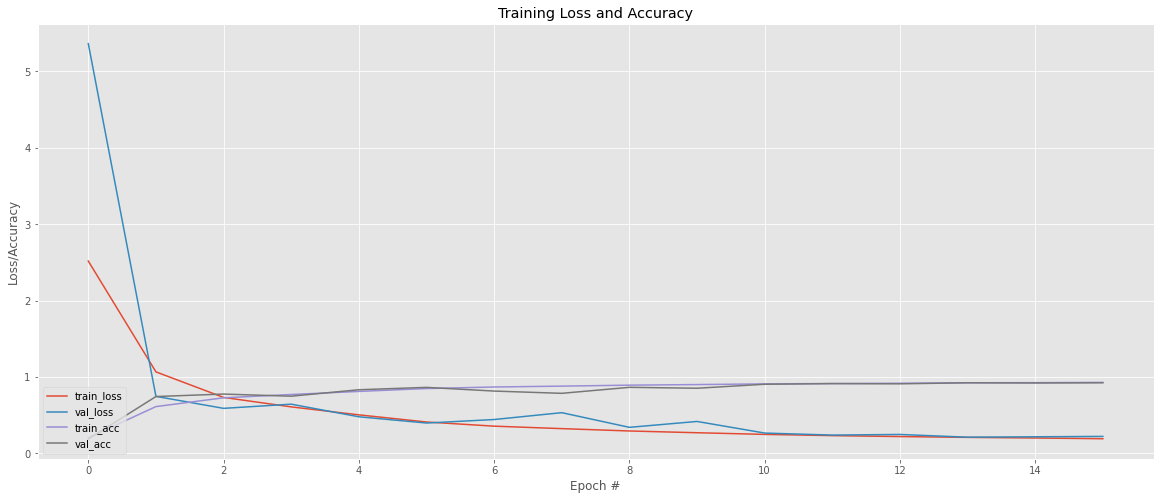

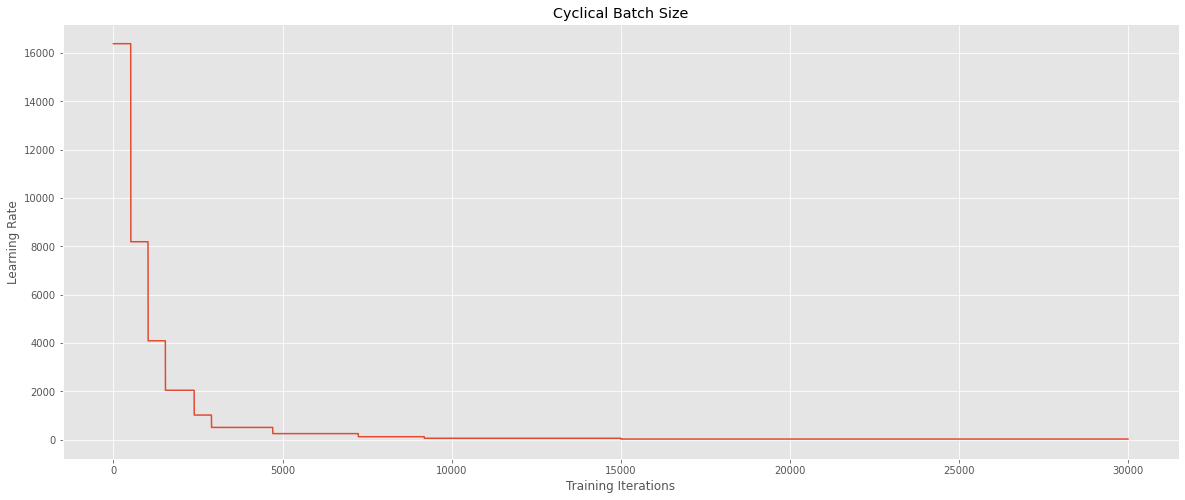

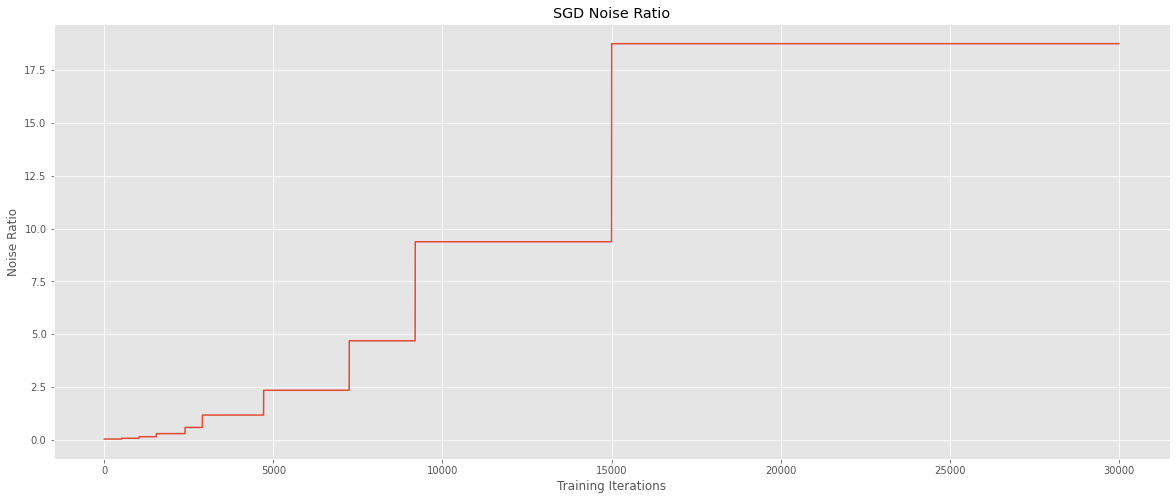

In [25]:
prefix = "BatchSizeVariationModel_"

# construct a plot that plots and saves the training history
N = np.arange(0, NUM_EPOCHS)
plt.style.use("ggplot")
plt.figure(figsize=(20,8))
plt.plot(N, history_object["loss"], label="train_loss")
plt.plot(N, history_object["val_loss"], label="val_loss")
plt.plot(N, history_object["accuracy"], label="train_acc")
plt.plot(N, history_object["val_accuracy"], label="val_acc")
plt.title("Training Loss and Accuracy")
plt.xlabel("Epoch #")
plt.ylabel("Loss/Accuracy")
plt.legend(loc="lower left")
plt.savefig(prefix+"AccuracyLoss.jpg", dpi=440)
plt.show()
# plot the learning rate history
N = np.arange(0, len(batchSizeVariation))
plt.figure(figsize=(20,8))
plt.plot(N, batchSizeVariation)
plt.title("Cyclical Batch Size")
plt.xlabel("Training Iterations")
plt.ylabel("Learning Rate")
plt.savefig(prefix+"SizeVariations.jpg", dpi=440)
plt.show()
# plot the learning rate history
N = np.arange(0, len(noiseRatio))
plt.figure(figsize=(20,8))
plt.plot(N, noiseRatio)
plt.title("SGD Noise Ratio")
plt.xlabel("Training Iterations")
plt.ylabel("Noise Ratio")
plt.savefig(prefix+"NoiseRatio.jpg", dpi=440)
plt.show()